In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.impute import KNNImputer
import pandas_profiling
import sweetviz
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from category_encoders import TargetEncoder
from sklearn.neighbors import KNeighborsClassifier
import geopy.distance as gp
%matplotlib inline

In [61]:
df_ = pd.read_csv("training_set_values.csv", parse_dates = ['date_recorded'])
df_lab_ = pd.read_csv("training_set_labels.csv")

In [62]:
df_w = df_.copy()
df_w.loc[df_w['longitude'] == 0, 'longitude'] = np.nan
df_w[df_w['longitude'] == 0]
#Impute the NANs created above with values according to the Imputation/KNN
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_w['longitude'] = imputer.fit_transform(df_w[['longitude']])

In [63]:
#Remove the unnecessary columns

df_w.drop(columns=['wpt_name',
                   'num_private',
                   'subvillage',
                   'region_code',
                   'scheme_name',
                   'recorded_by',
                   'payment',
                   'water_quality',
                   'extraction_type_group',
                   'management_group',
                   'quantity_group',
                   'source_type',
                   'waterpoint_type'], inplace= True)

In [64]:
#Add the target variable to the main dataframe and encode it with the values 0, 1 and 2

df_w['status_group'] = pd.Series(df_lab_['status_group']).map({"functional":0,"non functional":1,"functional needs repair":2})

In [65]:
#Impute the variable construction year on the basis of region and district code

df_w['construction_year'].replace(0.0, np.nan, inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['region'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w["construction_year"].median(), inplace=True)

In [66]:
df_w['population'].replace(0.0, np.nan, inplace=True)
df_w["population"].fillna(df_w.groupby(['region', 'district_code'])["population"].transform("mean"), inplace=True)
df_w["population"].fillna(df_w.groupby(['region'])["population"].transform("mean"), inplace=True)
df_w["population"].fillna(df_w.groupby(['district_code'])["population"].transform("mean"), inplace=True)
df_w["population"].fillna(df_w["population"].mean(), inplace=True)

In [67]:
# A function defined to create features from Date_recorded column
# This comes in handy while using tree based algorithms as those don't support categorical variables

def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
             'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)
    
#Use the above function to create additional features from Date column and drop the date column after features are created
add_datepart(df_w, 'date_recorded')    

In [68]:
mean_dodoma_long = df_w.loc[df_w['region'] == 'Dodoma']['longitude'].mean()
mean_dodoma_lat = df_w.loc[df_w['region'] == 'Dodoma']['latitude'].mean()

def fun(dframe):
    try:
        return gp.distance((dframe['latitude'],dframe['longitude']),(mean_dodoma_lat, mean_dodoma_long)).km
    except:
        return 0
df_w['distance_to_capital'] = df_w.apply(fun, axis = 1)

In [69]:
df_w['pump_age'] = 2021 - df_w['construction_year']

In [70]:
df_w['pop_age'] = df_w['population'] * df_w['pump_age']

In [71]:
#Separate out the list of numerical and categorical features

numerical_features = list(df_w.select_dtypes(exclude=['object']))
categorical_features = list(df_w.select_dtypes(include=['object']))
cardinal_features = ['funder','installer','lga','ward']

In [54]:
# #Performing Target Encoding for the categorical features
# from category_encoders import TargetEncoder
# encoder = TargetEncoder(cols=categorical_features)
# encoder.fit(df_w[categorical_features], df_w['status_group'])
# df_w[categorical_features] = encoder.transform(df_w[categorical_features])

In [72]:
from pycaret.classification import *
exp_ = setup(data = df_w, 
             target = 'status_group',
             train_size = 0.7,
             categorical_features= categorical_features,
             categorical_imputation = 'mode', 
             high_cardinality_features = cardinal_features,
             high_cardinality_method = 'clustering',
             remove_multicollinearity = True,
             remove_perfect_collinearity = True,
             fix_imbalance = True,
             normalize = True, 
             transformation = True,
             remove_outliers = True, 
             feature_selection = True,
             fold = 5, session_id=99)

,Description,Value
0,session_id,99
1,Target,status_group
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(59400, 43)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,28
8,Ordinal Features,False
9,High Cardinality Features,True


In [13]:
com = compare_models(['rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7939,0.9004,0.6832,0.7923,0.7926,0.6228,0.6235,19.7560
et,Extra Trees Classifier,0.7859,0.8916,0.6770,0.7845,0.7849,0.6091,0.6095,22.3840
catboost,CatBoost Classifier,0.7824,0.8930,0.6808,0.7844,0.7823,0.6027,0.6040,98.1880
xgboost,Extreme Gradient Boosting,0.7797,0.8927,0.6731,0.7808,0.7788,0.5960,0.5979,90.8780
lightgbm,Light Gradient Boosting Machine,0.7723,0.8861,0.6752,0.7770,0.7729,0.5849,0.5868,22.9080
dt,Decision Tree Classifier,0.7336,0.7679,0.6345,0.7395,0.7363,0.5227,0.5229,14.2760
gbc,Gradient Boosting Classifier,0.7234,0.8469,0.6410,0.7473,0.7304,0.5063,0.5101,70.5360
knn,K Neighbors Classifier,0.6952,0.8317,0.6679,0.7416,0.7114,0.4849,0.4915,36.8620
ada,Ada Boost Classifier,0.6574,0.7843,0.5882,0.6994,0.6725,0.4064,0.4109,16.7200
lr,Logistic Regression,0.6416,0.8274,0.6429,0.7442,0.6769,0.4239,0.4413,43.2360


In [73]:
rf_m = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7992,0.9038,0.6910,0.7975,0.7980,0.6328,0.6333
1,0.7930,0.8979,0.6798,0.7911,0.7914,0.6205,0.6213
2,0.7922,0.8986,0.6709,0.7890,0.7900,0.6186,0.6192
3,0.7957,0.9002,0.6847,0.7945,0.7946,0.6262,0.6269
4,0.7914,0.9000,0.6920,0.7916,0.7910,0.6195,0.6201
Mean,0.7943,0.9001,0.6837,0.7927,0.7930,0.6235,0.6242
SD,0.0029,0.0020,0.0078,0.0030,0.0029,0.0054,0.0053


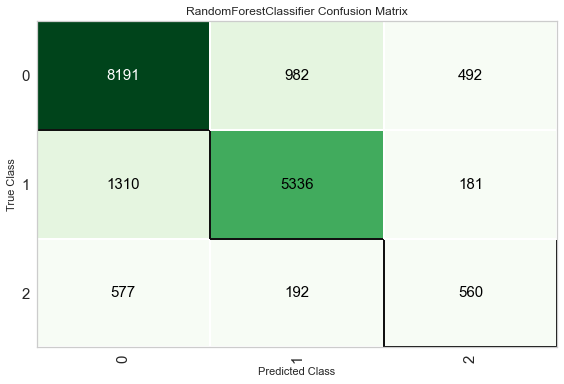

In [15]:
plot_model(rf_m, plot = 'confusion_matrix')

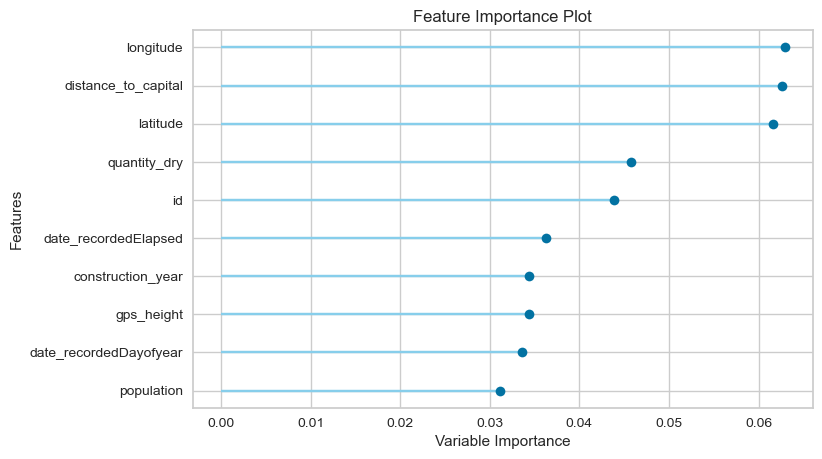

In [17]:
plot_model(rf_m, plot = 'feature')

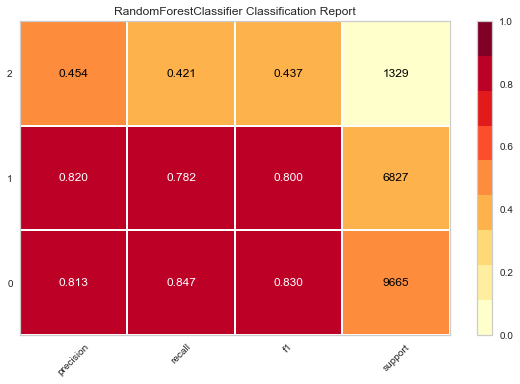

In [22]:
plot_model(rf_m, plot = 'class_report')

In [23]:
predict_model(rf_m);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7905,0.8968,0.6835,0.7887,0.7892,0.6178,0.6183


In [20]:
final_rf_nt = finalize_model(rf_m)

In [21]:
df_unseen = pd.read_csv("test_set_values.csv",parse_dates = ['date_recorded'])
df_unseen.drop(columns=['wpt_name',
                   'num_private',
                   'subvillage',
                   'region_code',
                   'scheme_name',
                   'recorded_by',
                   'payment',
                   'water_quality',
                   'extraction_type_group',
                   'management_group',
                   'quantity_group',
                   'source_type',
                   'waterpoint_type'], inplace= True)
add_datepart(df_unseen, 'date_recorded')
df_unseen['distance_to_capital'] = df_unseen.apply(fun, axis = 1)

In [24]:
unseen_predictions = predict_model(final_rf_nt, data=df_unseen)
print(unseen_predictions.head())
df_subm = unseen_predictions[['id', 'Label']]
df_subm = df_subm.rename(columns = {'Label': 'status_group'})
df_subm['status_group'] = pd.Series(df_subm['status_group']).map({0:"functional",1:"non functional",2:"functional needs repair"})
df_subm.to_csv("submission_2.csv", index = False)

      id  amount_tsh                  funder  gps_height   installer  \
0  50785         0.0                    Dmdd        1996        DMDD   
1  51630         0.0  Government Of Tanzania        1569         DWE   
2  17168         0.0                     NaN        1567         NaN   
3  45559         0.0              Finn Water         267  FINN WATER   
4  49871       500.0                  Bruder        1260      BRUDER   

   longitude   latitude                    basin   region  district_code  ...  \
0  35.290799  -4.059696                 Internal  Manyara              3  ...   
1  36.656709  -3.309214                  Pangani   Arusha              2  ...   
2  34.767863  -5.004344                 Internal  Singida              2  ...   
3  38.058046  -9.418672  Ruvuma / Southern Coast    Lindi             43  ...   
4  35.006123 -10.950412  Ruvuma / Southern Coast   Ruvuma              3  ...   

  date_recordedIs_month_end date_recordedIs_month_start  \
0                    

### With feature engineering

1. Add feature importance
2. Why XG Boost didn't 
3. What would you do if more time/compute - Try Auto ML

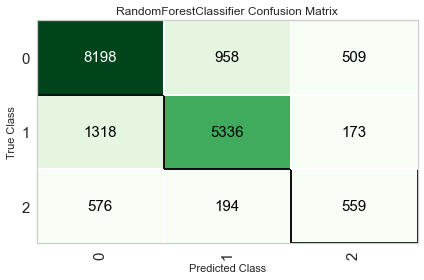

In [74]:
plot_model(rf_m, plot = 'confusion_matrix')

In [75]:
predict_model(rf_m);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7908,0.8975,0.6835,0.7892,0.7896,0.6184,0.6190


In [76]:
final_rf_nt_fe = finalize_model(rf_m)

In [81]:
df_unseen = pd.read_csv("test_set_values.csv",parse_dates = ['date_recorded'])
df_unseen.drop(columns=['wpt_name',
                   'num_private',
                   'subvillage',
                   'region_code',
                   'scheme_name',
                   'recorded_by',
                   'payment',
                   'water_quality',
                   'extraction_type_group',
                   'management_group',
                   'quantity_group',
                   'source_type',
                   'waterpoint_type'], inplace= True)
add_datepart(df_unseen, 'date_recorded')
df_unseen['distance_to_capital'] = df_unseen.apply(fun, axis = 1)

df_unseen['construction_year'].replace(0.0, np.nan, inplace=True)
df_unseen["construction_year"].fillna(df_unseen.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
df_unseen["construction_year"].fillna(df_unseen.groupby(['region'])["construction_year"].transform("median"), inplace=True)
df_unseen["construction_year"].fillna(df_unseen.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
df_unseen["construction_year"].fillna(df_unseen["construction_year"].median(), inplace=True)

df_unseen['population'].replace(0.0, np.nan, inplace=True)
df_unseen["population"].fillna(df_unseen.groupby(['region', 'district_code'])["population"].transform("mean"), inplace=True)
df_unseen["population"].fillna(df_unseen.groupby(['region'])["population"].transform("mean"), inplace=True)
df_unseen["population"].fillna(df_unseen.groupby(['district_code'])["population"].transform("mean"), inplace=True)
df_unseen["population"].fillna(df_unseen["population"].mean(), inplace=True)

df_unseen['pump_age'] = 2021 - df_unseen['construction_year']
df_unseen['pop_age'] = df_unseen['population'] * df_unseen['pump_age']
df_unseen['longitude'] = imputer.transform(df_unseen[['longitude']])


In [82]:
unseen_predictions_rf_fe = predict_model(rf_m, data=df_unseen)
#print(unseen_predictions_rf_fe.head())
df_subm_fe = unseen_predictions_rf_fe[['id', 'Label']]
df_subm_fe = df_subm_fe.rename(columns = {'Label': 'status_group'})
df_subm_fe['status_group'] = pd.Series(df_subm_fe['status_group']).map({0:"functional",1:"non functional",2:"functional needs repair"})
df_subm_fe.to_csv("submission_fe.csv", index = False)

In [83]:
unseen_predictions_rf_fe

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,...,date_recordedIs_quarter_end,date_recordedIs_quarter_start,date_recordedIs_year_end,date_recordedIs_year_start,date_recordedElapsed,distance_to_capital,pump_age,pop_age,Label,Score
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Internal,Manyara,3,...,False,False,False,False,4333,222.929938,9.0,2889.0,0,0.45
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Pangani,Arusha,2,...,False,False,False,False,4333,297.536468,21.0,6300.0,0,0.45
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Internal,Singida,2,...,False,False,False,False,4330,174.508590,11.0,5500.0,0,0.72
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,43,...,False,False,False,False,4320,445.334700,34.0,8500.0,1,0.97
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,3,...,False,False,False,False,4384,567.026078,21.0,1260.0,0,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,Danida,34,Da,38.852669,-6.582841,Wami / Ruvu,Pwani,1,...,False,False,False,False,3622,319.096231,33.0,660.0,1,0.80
14846,18990,1000.0,Hiap,0,HIAP,37.451633,-5.350428,Pangani,Tanga,7,...,False,False,False,False,3647,168.529356,27.0,79920.0,0,0.75
14847,28749,0.0,NaN,1476,NaN,34.739804,-4.585587,Internal,Singida,2,...,False,False,False,False,4361,207.286811,11.0,2200.0,0,0.60
14848,33492,0.0,Germany,998,DWE,35.432732,-10.584159,Lake Nyasa,Ruvuma,2,...,False,False,False,False,4347,519.265150,12.0,1800.0,0,0.75


### Hyperparameter Tuning

In [26]:
tuned_rf = tune_model(rf_m, search_library = 'optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7248,0.8643,0.6847,0.7784,0.7392,0.5216,0.5307
1,0.7123,0.8575,0.6774,0.7711,0.7282,0.5025,0.5123
2,0.7120,0.8590,0.6641,0.7700,0.7286,0.5009,0.5100
3,0.7119,0.8614,0.6752,0.7744,0.7305,0.5055,0.5153
4,0.7257,0.8671,0.6946,0.7832,0.7411,0.5251,0.5349
Mean,0.7173,0.8619,0.6792,0.7754,0.7335,0.5111,0.5206
SD,0.0065,0.0035,0.0102,0.0049,0.0055,0.0102,0.0102


In [27]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7198,0.8638,0.6839,0.7767,0.7362,0.5175,0.5265


,region_Rukwa,extraction_type_submersible,scheme_management_Company,quantity_seasonal,quantity_insufficient,management_wug,lga_0,payment_type_unknown,quality_group_unknown,region_Manyara,...,source_class_groundwater,basin_Internal,gps_height,scheme_management_VWC,region_Mwanza,region_Lindi,basin_Wami / Ruvu,status_group,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,-1.033676,0.0,0.0,0.0,0.0,2,2,0.8676
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.671158,1.0,0.0,0.0,0.0,0,0,0.4761
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.873115,1.0,0.0,0.0,0.0,0,0,0.5068
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.142422,1.0,0.0,0.0,0.0,1,0,0.5452
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.280877,1.0,0.0,0.0,0.0,1,1,0.9361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.447757,1.0,0.0,1.0,0.0,1,1,0.9928
17817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.209035,1.0,0.0,0.0,0.0,1,1,0.9800
17818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-1.006626,1.0,0.0,0.0,1.0,0,1,0.7379
17819,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.675116,1.0,0.0,0.0,0.0,0,0,0.9567


In [31]:
print(tuned_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features=0.48891355249671514,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=7.263319911036792e-07,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=194, n_jobs=-1, oob_score=False,
                       random_state=99, verbose=0, warm_start=False)


In [29]:
final_rf_t = finalize_model(tuned_rf)

In [30]:
unseen_predictions = predict_model(tuned_rf, data=df_unseen)
print(unseen_predictions.head())
df_subm = unseen_predictions[['id', 'Label']]
df_subm = df_subm.rename(columns = {'Label': 'status_group'})
df_subm['status_group'] = pd.Series(df_subm['status_group']).map({0:"functional",1:"non functional",2:"functional needs repair"})
df_subm.to_csv("submission_3.csv", index = False)

      id  amount_tsh                  funder  gps_height   installer  \
0  50785         0.0                    Dmdd        1996        DMDD   
1  51630         0.0  Government Of Tanzania        1569         DWE   
2  17168         0.0                     NaN        1567         NaN   
3  45559         0.0              Finn Water         267  FINN WATER   
4  49871       500.0                  Bruder        1260      BRUDER   

   longitude   latitude                    basin   region  district_code  ...  \
0  35.290799  -4.059696                 Internal  Manyara              3  ...   
1  36.656709  -3.309214                  Pangani   Arusha              2  ...   
2  34.767863  -5.004344                 Internal  Singida              2  ...   
3  38.058046  -9.418672  Ruvuma / Southern Coast    Lindi             43  ...   
4  35.006123 -10.950412  Ruvuma / Southern Coast   Ruvuma              3  ...   

  date_recordedIs_month_end date_recordedIs_month_start  \
0                    